# Breast Cancer Detection Feasibility

Breast cancer is one of the most diagnosed cancers in the world, with it being the most common cancer diagnosed in women. Although there have been significant breakthroughs in breast cancer treatment and prevention, methods for diagnosing it such as mammograms have their limitations. Image quality, cancer type, density of breast tissue, and human error all contribute to the 15-20% false negative rate of mammograms. This project aims to offer a more accurate way of detecting breast cancer by using AI to classify pictures of tumors in mammograms as malignant or benign. All 3,383 images come from this [Kaggle dataset](https://www.kaggle.com/datasets/hayder17/breast-cancer-detection/data).

In [14]:
import numpy as np
import keras
from tensorflow.keras import layers
from tensorflow import data as tf_data
import matplotlib.pyplot as plt
from tensorflow.keras import optimizers

First, let's unzip the file and take a look at the directories inside.

In [2]:
!ls 

'Computer Vision Feasibility.ipynb'   breast-cancer-detection.zip


In [3]:
!unzip *.zip

Archive:  breast-cancer-detection.zip
  inflating: test/0/105_1934323665_png.rf.a1e70bb0747c86f17a76a13894e8e191.jpg  
  inflating: test/0/1588_1603972171_png.rf.29f8eb427de2e92c2222298b7b497ad0.jpg  
  inflating: test/0/1588_274144628_png.rf.58cbfa689d58bca33eb53a98e2a44cb1.jpg  
  inflating: test/0/1601_364263039_png.rf.8a3b35c9dad8729063a9d9ab60fe3c1a.jpg  
  inflating: test/0/1601_751935569_png.rf.6f6ec0c9f80d50a36684d99c4bee20d0.jpg  
  inflating: test/0/1607_1416980837_png.rf.8552d91ecac36ed533f1a2a53ca77740.jpg  
  inflating: test/0/1638_1923297632_png.rf.ac117130fda038f0ce846f93eb001779.jpg  
  inflating: test/0/1649_1117924917_png.rf.8256b936a9d187da0807adc99545ee08.jpg  
  inflating: test/0/1649_428595380_png.rf.67c04778f1beca13be9fc29331df8b40.jpg  
  inflating: test/0/1657_2120850106_png.rf.2436bb2abb4f49855f5d507e3b638975.jpg  
  inflating: test/0/1688_550590619_png.rf.a04a2c456c261683e4e485eaac805f26.jpg  
  inflating: test/0/1701_2097469936_png.rf.1fa2b27ddefb835a10f416d

The photos are divided into three separate directories for training, testing, and validation sets. Each set contains photos of benign tumors (0) or malignant tumors(1).

In [4]:
!ls

'Computer Vision Feasibility.ipynb'   test    valid
 breast-cancer-detection.zip	      train


In [5]:
!ls train

0  1


In [6]:
!ls valid

0  1


In [7]:
!ls test

0  1


First, let's load the data and take a look at the images. For now, we'll just take a look at the validation and training sets.

In [8]:
# Converting the images sizes down to 224x224 from the original 640x640 and setting a smaller batch size 
# since my laptop is kind of slow.
image_size = (224, 224)
batch_size = 10

# Load in the training set
train_ds = keras.utils.image_dataset_from_directory(
    "train",
    image_size=image_size,
    batch_size=batch_size,
    label_mode = "binary"
)

# Load in the validation set
valid_ds = keras.utils.image_dataset_from_directory(
    "valid",
    image_size=image_size,
    batch_size=batch_size,
    label_mode = "binary"
)

Found 2372 files belonging to 2 classes.


2025-07-12 21:18:20.401037: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Found 675 files belonging to 2 classes.


/tmp/ipykernel_535/1612354969.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())


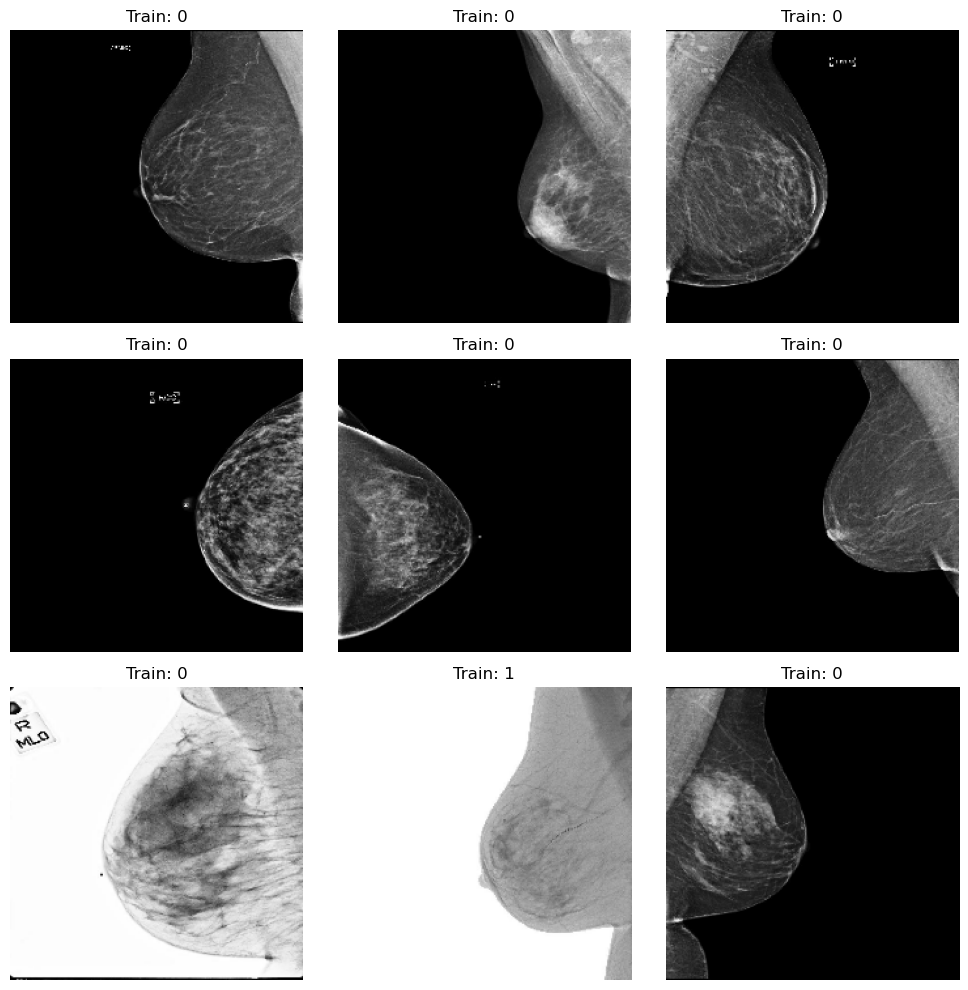

/tmp/ipykernel_535/1612354969.py:23: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  label = int(labels[i].numpy())


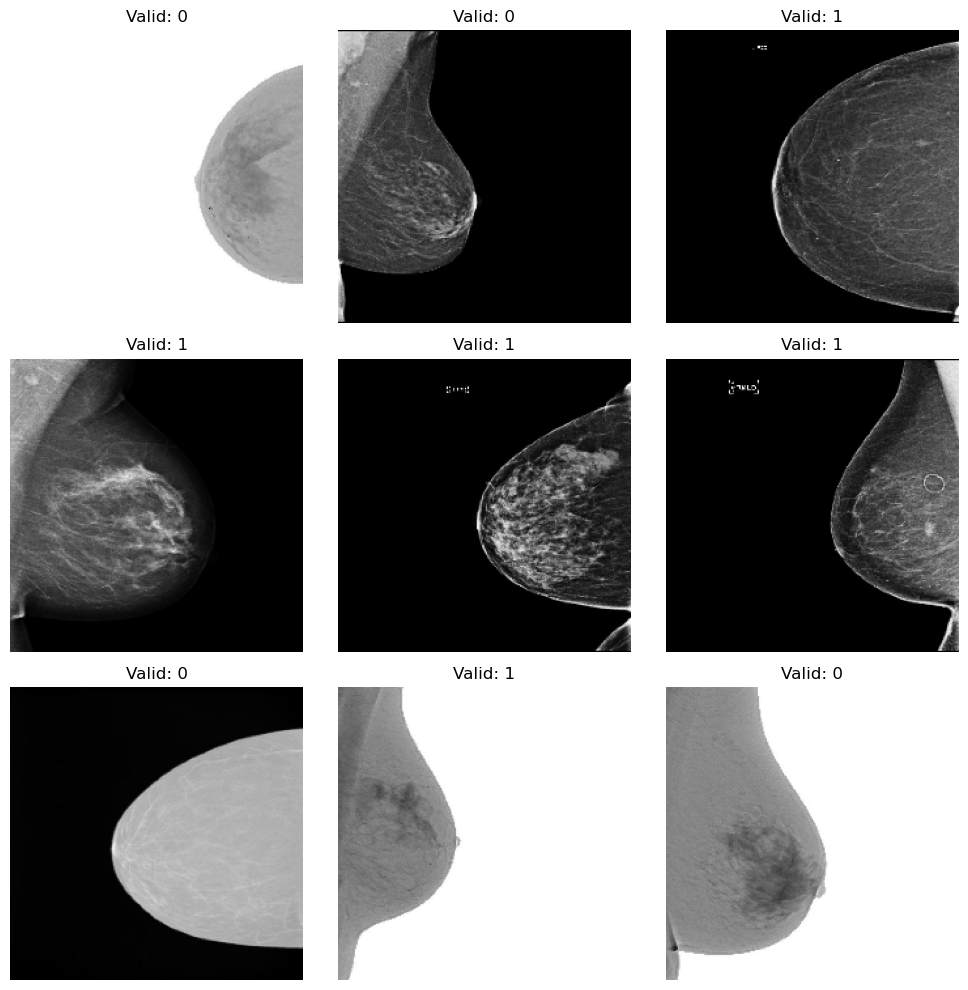

In [12]:
# Get class labels
class_names = train_ds.class_names

# Show a batch of training images
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i].numpy())
        plt.title(f"Train: {class_names[label]}")
        plt.axis("off")
        
plt.tight_layout()
plt.show()

# Show a batch of validation images
plt.figure(figsize=(10, 10))
for images, labels in valid_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        label = int(labels[i].numpy())
        plt.title(f"Valid: {class_names[label]}")
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [13]:
# Prefetching samples in GPU memory helps maximize GPU utilization.
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
valid_ds = valid_ds.prefetch(tf_data.AUTOTUNE)

For this project, I'll be using a pre-trained model to classify these images as opposed to training a model from scratch. Let's just focus on getting a baseline model that works and shows this project is possible.

In [15]:
# Function that will create a one of the pre-trained models that Keras offers

def make_transfer_model(input_shape, num_classes):
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = keras.applications.MobileNetV2(
        weights="imagenet",
        include_top=False,
        input_shape=input_shape,
    )
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    
    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        units = 1
    else:
        units = num_classes

    x = layers.Dropout(0.25)(x)
    # We specify activation=None so as to return logits
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="keypoint_detector")

In [16]:
model2 = make_transfer_model(input_shape=image_size + (3,), num_classes=2)

In [17]:
epochs = 8

optimizer = optimizers.Adam(learning_rate=0.001)

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]

model2.compile(
    optimizer=optimizer,
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
)

history = model2.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=valid_ds,
)

Epoch 1/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 75s 295ms/step - acc: 0.6541 - loss: 0.7151 - val_acc: 0.6637 - val_loss: 0.6708
Epoch 2/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 68s 285ms/step - acc: 0.6777 - loss: 0.6328 - val_acc: 0.6770 - val_loss: 0.6299
Epoch 3/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 65s 272ms/step - acc: 0.6771 - loss: 0.6221 - val_acc: 0.6711 - val_loss: 0.6322
Epoch 4/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 56s 236ms/step - acc: 0.6746 - loss: 0.6081 - val_acc: 0.6667 - val_loss: 0.6265
Epoch 5/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 86s 254ms/step - acc: 0.6738 - loss: 0.6130 - val_acc: 0.6696 - val_loss: 0.6346
Epoch 6/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 70s 295ms/step - acc: 0.6941 - loss: 0.5891 - val_acc: 0.6652 - val_loss: 0.6188
Epoch 7/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 62s 262ms/step - acc: 0.6829 - loss: 0.5789 - val_acc: 0.6696 - val_loss: 0.6356
Epoch 8/8
238/238 ━━━━━━━━━━━━━━━━━━━━ 54s 227ms/step - acc: 0.6874 - loss: 0.5793 - val_acc: 0.6607 - val_loss: 0.6198


Not the best results, but it shows this project is workable! I'm sure we'll get a better result after some image processing and changing some model parameters.

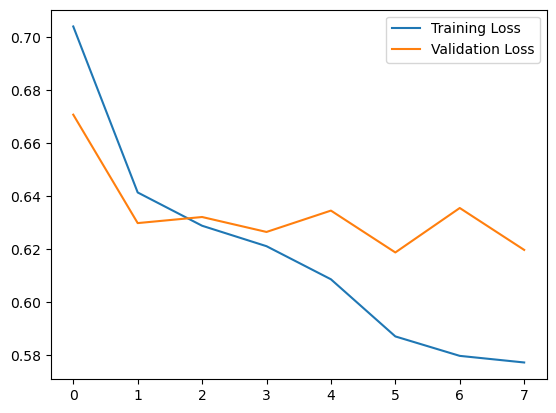

In [19]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.legend()
plt.show()

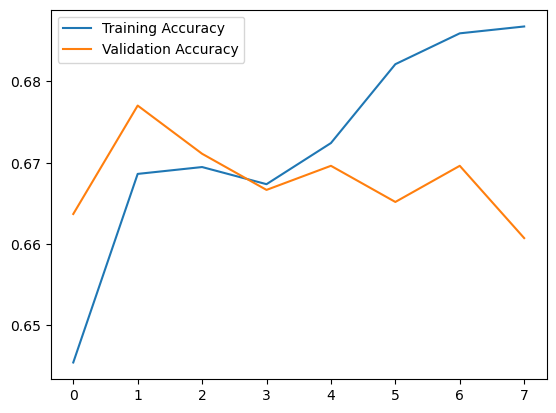

In [20]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.legend()
plt.show()